# Comparing Models on the ExtraSensory dataset


## Set up the Notebook

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import importlib, sys, os
sys.path.insert(0, os.path.abspath('..'))
if(importlib.util.find_spec("mFlow") is None):
    !git clone https://github.com/mlds-lab/mFlow.git
    !pip install ./mFlow
else:
    print("mFlow module found")

mFlow module found


## Import modules

In [3]:
from mFlow.Blocks.data_loader_extrasensory import extrasensory_data_loader
from mFlow.Blocks.filter import MisingLabelFilter,  MisingDataColumnFilter, Take
from mFlow.Blocks.imputer import Imputer
from mFlow.Blocks.normalizer import Normalizer
from mFlow.Blocks.experimental_protocol import ExpTrainTest, ExpCV, ExpWithin
from mFlow.Blocks.results_analysis import ResultsConcat, ResultsCVSummarize, DataYieldReport

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score 
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC

import matplotlib.pyplot as plt

from mFlow.Workflow.workflow import workflow
import mFlow.Workflow.compute_graph


## Define the workflow

This workflow uses a basic train/test experiment to compare the use of several different Scikit-Learn classification models including a "guess the majority class" model, decision trees, logistic regression, RBF kernel SVMs, and KNN. The experiment uses the first 50,000  instances in the ExtraSensory data set. 

The workflow includes a column filter that screens out feature dimensions that are less than 20% observed, a missing label filter that removes instances without labels, mean imputation, and normalization. Next, the workflow includes one branch performing a train/test experiment for each model. Pre-processing is shared across all branches of the workflow. 

In the results below, we can see a 15% spread in accuracy across methods. However, the model hyper-parameters have not been optimized for any of the models, so the comparison is relatively meaningless. The hyper-parameters need to first be optimized before the models can be compared. This can be accomplished by wrapping the estimators in Scikit-Learns grid search cross-validation wrapper. See ExtraSensory-ComparingModels-NestedCV.ipynb for an example of nesting cross validation within experimental protocols. 

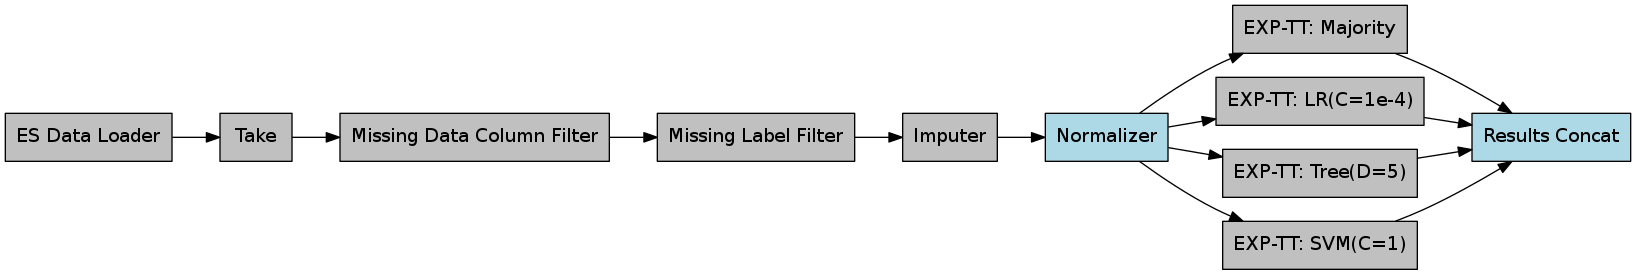

In [4]:
df_raw      = extrasensory_data_loader(label="SLEEPING");
df_raw      = Take(df_raw, 50000)
df_cf       = MisingDataColumnFilter(df_raw);
df_lf       = MisingLabelFilter(df_cf);
df_imp      = Imputer(df_lf, method="mean")
df_norm     = Normalizer(df_imp)

metrics     = [accuracy_score, f1_score, precision_score, recall_score]

models = {
              "Majority":   DummyClassifier(strategy="most_frequent"),
              "LR(C=1e-4)": LogisticRegression(C=1e-4, solver="lbfgs",max_iter=1000),
              "Tree(D=5)":  tree.DecisionTreeClassifier(max_depth=5),
              "SVM(C=1)":   SVC(C=1, gamma="auto", max_iter=100)
        }

res     = ExpTrainTest(df_norm, models, metrics=metrics);
res_cat = ResultsConcat(res)
flow    = workflow({"results":res_cat, "data":df_norm})
 
flow.draw(); plt.show();
output=flow.run(backend="sequential", monitor=True, from_scratch=True);

In [5]:
display(output["results"]["report"])

,accuracy_score,f1_score,precision_score,recall_score
Majority,0.695436,0.000000,0.000000,0.000000
LR(C=1e-4),0.708002,0.140314,0.679054,0.078241
Tree(D=5),0.671014,0.028021,0.139860,0.015570
SVM(C=1),0.841849,0.698735,0.832168,0.602180


In [6]:
display(output["data"]["dataframe"])

watch_acceleration:spectrum:z_log_energy_band0  \
ID                                   Time                                                   
00EABED2-271D-49D8-B599-1D4A09240601 0                                          -1.006532   
                                     1                                          -1.020476   
                                     2                                          -1.002283   
                                     3                                          -1.018865   
                                     4                                          -1.234198   
...                                                                                   ...   
1DBB0F6F-1F81-4A50-9DF4-CD62ACFA4842 2009                                       -1.052640   
                                     2010                                       -1.263758   
                                     2011                                       -1.234367   
                                     2012                                       -0.733782   
                                     2013                                       -1.223752   

                                           raw_acc:magnitude_stats:percentile75  \
ID                                   Time                                         
00EABED2-271D-49D8-B599-1D4A09240601 0                                -0.146602   
                                     1                                -0.132543   
                                     2                                -0.135845   
                                     3                                -0.136591   
                                     4                                -0.162418   
...                                                                         ...   
1DBB0F6F-1F81-4A50-9DF4-CD62ACFA4842 2009                             14.298662   
                                     2010                             11.782627   
                                     2011                             10.672329   
                                     2012                             -1.559316   
                                     2013                             -1.110564   

                                           proc_gyro:3d:std_x  \
ID                                   Time                       
00EABED2-271D-49D8-B599-1D4A09240601 0              -0.013451   
                                     1              -0.016263   
                                     2              -0.013254   
                                     3              -0.021255   
                                     4               2.120871   
...                                                       ...   
1DBB0F6F-1F81-4A50-9DF4-CD62ACFA4842 2009           23.503000   
                                     2010           22.858174   
                                     2011           23.256528   
                                     2012            4.544153   
                                     2013           24.353642   

                                           proc_gyro:3d:std_y  \
ID                                   Time                       
00EABED2-271D-49D8-B599-1D4A09240601 0              -0.003085   
                                     1              -0.006197   
                                     2               0.000232   
                                     3               0.001691   
                                     4               4.134236   
...                                                       ...   
1DBB0F6F-1F81-4A50-9DF4-CD62ACFA4842 2009           13.242440   
                                     2010           11.761324   
                                     2011           12.755430   
                                     2012            3.659969   
                                     2013           12.909599   

                                           audio_naive:mfcc10